```
@title : Tracker X data analysis
@date  : 20250130 ALUR
@author: Aleksandras Urbonas
```


#
# Step 1. Load the data
Load the files (Activity Sessions, Daily Health Metrics, and Health Metrics Samples) into `Pandas DataFrames`.
#

In [1]:


import pandas as pd  # load and process data
import numpy as np  # process numeric values



##
## Daily
##

In [2]:


# Load the data
daily__raw = pd.read_csv(
    '../data/00_original/health_metrics_daily_2025-01-28.csv'
# , index_col='PK_HEALTH_METRICS_HEART_ID'
)

# preview
daily__raw.head(2)



,PK_HEALTH_METRICS_HEART_ID,FK_USER_ID,DATE,TIMEZONE_OFFSET,RESTING_HR,MIN_HR,AVG_HR,MAX_HR,SOURCE,HEART_RATE_VARIABILITY_DAY_HRV,HEART_RATE_VARIABILITY_SLEEP_HRV,CREATED_DATE,LAST_MODIFIED_DATE,ROW_IS_VALID
0,1,14064,2024-09-08,10800,65.0,60,73.0,133,apple,NaN,NaN,2024-09-11 09:56:50,2024-09-11 09:56:50,1
1,2,14064,2024-09-09,10800,65.0,60,73.0,133,apple,NaN,NaN,2024-09-11 09:56:52,2024-09-11 09:56:52,1


In [3]:


# working dataset
daily__dev = daily__raw.copy()



In [4]:


# columns check
daily__dev.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166409 entries, 0 to 166408
Data columns (total 14 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   PK_HEALTH_METRICS_HEART_ID        166409 non-null  int64  
 1   FK_USER_ID                        166409 non-null  int64  
 2   DATE                              166409 non-null  object 
 3   TIMEZONE_OFFSET                   166409 non-null  int64  
 4   RESTING_HR                        140727 non-null  float64
 5   MIN_HR                            166409 non-null  int64  
 6   AVG_HR                            166377 non-null  float64
 7   MAX_HR                            166409 non-null  int64  
 8   SOURCE                            166409 non-null  object 
 9   HEART_RATE_VARIABILITY_DAY_HRV    0 non-null       float64
 10  HEART_RATE_VARIABILITY_SLEEP_HRV  0 non-null       float64
 11  CREATED_DATE                      166409 non-null  o

In [5]:


# only keep valid rows
daily__dev = daily__dev[daily__dev['ROW_IS_VALID'] == 1]

del daily__dev['ROW_IS_VALID']



In [6]:


# drop timezone: already included
del daily__dev['TIMEZONE_OFFSET']



In [7]:


# drop system timestamps
del daily__dev['CREATED_DATE']
del daily__dev['LAST_MODIFIED_DATE']



In [8]:


# A-1. invalid date in on row:
drop_daily_date_idx = daily__dev[daily__dev['DATE'] == '0001-01-01'].index
# FK_USER_ID=21775, PK_HEALTH_METRICS_HEART_ID=790

# A-2. drop invalid row
daily__dev = daily__dev.drop(drop_daily_date_idx)



In [9]:


# B. convert datetime
daily__dev['DATE'] = pd.to_datetime(daily__dev['DATE']) #, format='mixed')
daily__dev['DATE'] = daily__dev['DATE'].dt.date #, format='mixed')

# Error:
# OutOfBoundsDatetime: Out of bounds nanosecond timestamp: 0001-01-01, at position 5. You might want to try:
#     - passing `format` if your strings have a consistent format;
#     - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
#     - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

# rename date column:
daily__dev.rename({'DATE':'DAILY_DATE'}, axis='columns', inplace=True)



In [10]:


# Check for missing data
print(daily__dev.isnull().sum())



PK_HEALTH_METRICS_HEART_ID               0
FK_USER_ID                               0
DAILY_DATE                               0
RESTING_HR                           25681
MIN_HR                                   0
AVG_HR                                  32
MAX_HR                                   0
SOURCE                                   0
HEART_RATE_VARIABILITY_DAY_HRV      166408
HEART_RATE_VARIABILITY_SLEEP_HRV    166408
dtype: int64


In [11]:


# A-1. invalid date in on row:
drop_daily_avg_hr_idx = daily__dev[daily__dev['AVG_HR'].isnull()].index
# FK_USER_ID=21775, PK_HEALTH_METRICS_HEART_ID=790

# A-2. drop invalid row
daily__dev = daily__dev.drop(drop_daily_avg_hr_idx)



In [12]:


del daily__dev['HEART_RATE_VARIABILITY_DAY_HRV']  # all null
del daily__dev['HEART_RATE_VARIABILITY_SLEEP_HRV']  # all null



In [13]:


# review missing data
# daily__dev[daily__dev['RESTING_HR'].isnull()].head(1)
# 15-20% are null negative timezeone?

# removing: out of scope. focus on AVG_HR.
del daily__dev['RESTING_HR']
del daily__dev['MIN_HR']
del daily__dev['MAX_HR']



In [14]:


# Select first user in data
# users_sample_list = 14064

# Randomly sample N users
# users_sample_list = daily__dev['FK_USER_ID'].sample(n=1000, random_state=88888888).to_list()
# # use list from Sessions
# print(f"* Users sampled: {users_sample_list[:3]}")

# select sample of users
# daily__user = daily__dev[daily__dev['FK_USER_ID'].isin(users_sample_list)]

# or go full
daily__user = daily__dev
print(f"* Rows selected: {daily__user.shape[0]}")

# Preview
daily__user.head(2)

# 143 records
# FK: PK_HEALTH_METRICS_HEART_ID



* Rows selected: 166376


,PK_HEALTH_METRICS_HEART_ID,FK_USER_ID,DAILY_DATE,AVG_HR,SOURCE
0,1,14064,2024-09-08,73.0,apple
1,2,14064,2024-09-09,73.0,apple


In [15]:


#summary
daily__user.describe()



,PK_HEALTH_METRICS_HEART_ID,FK_USER_ID,AVG_HR
count,166376.000000,166376.000000,166376.000000
mean,83202.463210,40798.078990,77.023723
std,48038.772859,15566.595162,12.990491
min,1.000000,120.000000,-15.000000
25%,41598.750000,31339.000000,69.000000
50%,83203.500000,41537.000000,76.000000
75%,124804.250000,53507.000000,84.000000
max,166409.000000,76004.000000,181.000000


In [16]:


# write to file for analysis
daily__user.to_csv('daily__user.csv')



##
## Sessions
##

In [17]:


# Load the data
sessions__raw = pd.read_csv(
    '../data/00_original/activity_sessions_2025-01-28.csv'
# , index_col='PK_ACTIVITY_SESSION_ID'
, low_memory=False  # DtypeWarning: Columns (13,14) have mixed types
)

# preview
sessions__raw.head(2)



,PK_ACTIVITY_SESSION_ID,CREATED_DATE,LAST_MODIFIED_DATE,ROW_IS_VALID,FK_USER_ID,FK_SYSTEM_PROGRAM_ID,START_DATE,END_DATE,FK_REFERENCE_ID,SESSION_TYPE,IS_FINISHED,INTENSITY,RATING,RATING_ISSUE,RATING_ISSUE_MESSAGE
0,1,2024-04-02 11:15:07,2024-04-02 11:15:07,1,3,1,2024-04-02 11:09:40,2024-04-02 11:15:07,1,Program,1,NaN,NaN,NaN,NaN
1,2,2024-04-04 07:51:07,2024-04-04 07:51:07,1,215,1,2024-04-04 07:47:05,2024-04-04 07:51:07,1,Program,1,NaN,NaN,NaN,NaN


In [18]:


# working copy
sessions__dev = sessions__raw.copy()



In [19]:


# review dataset
sessions__dev.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1930677 entries, 0 to 1930676
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   PK_ACTIVITY_SESSION_ID  int64  
 1   CREATED_DATE            object 
 2   LAST_MODIFIED_DATE      object 
 3   ROW_IS_VALID            int64  
 4   FK_USER_ID              int64  
 5   FK_SYSTEM_PROGRAM_ID    int64  
 6   START_DATE              object 
 7   END_DATE                object 
 8   FK_REFERENCE_ID         int64  
 9   SESSION_TYPE            object 
 10  IS_FINISHED             int64  
 11  INTENSITY               float64
 12  RATING                  float64
 13  RATING_ISSUE            object 
 14  RATING_ISSUE_MESSAGE    object 
dtypes: float64(2), int64(6), object(7)
memory usage: 220.9+ MB


In [20]:


# Check for missing data
print(sessions__dev.isnull().sum())
# INTENSITY                  684883
# RATING                    1491032
# RATING_ISSUE              1928737
# RATING_ISSUE_MESSAGE      1930085



PK_ACTIVITY_SESSION_ID          0
CREATED_DATE                    0
LAST_MODIFIED_DATE              0
ROW_IS_VALID                    0
FK_USER_ID                      0
FK_SYSTEM_PROGRAM_ID            0
START_DATE                      0
END_DATE                        0
FK_REFERENCE_ID                 0
SESSION_TYPE                    0
IS_FINISHED                     0
INTENSITY                  684883
RATING                    1491032
RATING_ISSUE              1928737
RATING_ISSUE_MESSAGE      1930085
dtype: int64


In [21]:


# include only valid rows
sessions__dev = sessions__dev[sessions__dev['ROW_IS_VALID'] == 1]
# delete redundant columns:
del sessions__dev['ROW_IS_VALID']



In [22]:


# include: only finished sessions
sessions__dev = sessions__dev[sessions__dev['IS_FINISHED'] == 1]
# delete redundant columns
del sessions__dev['IS_FINISHED']



In [23]:


# remove primary key, unused:
del sessions__dev['PK_ACTIVITY_SESSION_ID']



In [24]:


# delete redundant system columns
del sessions__dev['CREATED_DATE']  # end of session: out of scope
del sessions__dev['LAST_MODIFIED_DATE']  # use for modifications: out of scope



In [25]:


# Ratings: few records have such info: DECISION to remove from current analysis
del sessions__dev['RATING']
del sessions__dev['RATING_ISSUE']
del sessions__dev['RATING_ISSUE_MESSAGE']



In [26]:


# FK_SYSTEM_PROGRAM_ID == FK_REFERENCE_ID?
print(sessions__dev['FK_SYSTEM_PROGRAM_ID'][sessions__dev['FK_SYSTEM_PROGRAM_ID'] != sessions__dev['FK_REFERENCE_ID']].count())

# FK_SYSTEM_PROGRAM_ID=0, when INTENSITY variable is populated.
# So, FK_REFERENCE_ID is more specific.
# DECISION: remove less specific variable
del sessions__dev['FK_SYSTEM_PROGRAM_ID']



1245758


In [27]:


# convert to datetime 
sessions__dev['START_DATETIME'] = pd.to_datetime(sessions__dev['START_DATE'])
sessions__dev['END_DATETIME'] = pd.to_datetime(sessions__dev['END_DATE'])

# del sessions__dev['START_DATE']
del sessions__dev['END_DATE']

# extract dates from datetime
sessions__dev['START_DATE'] = sessions__dev['START_DATETIME'].dt.date
# sessions__dev['END_DATE'] = sessions__dev['END_DATETIME'].dt.date



In [28]:


# Calc: Add time-based features for analysis
sessions__dev['SESSION_DURATION'] = (sessions__dev['END_DATETIME'] - sessions__dev['START_DATETIME']).dt.total_seconds()
# preview
sessions__dev['SESSION_DURATION'].head(2)



0    327.0
1    242.0
Name: SESSION_DURATION, dtype: float64

In [29]:

# sample one: first
# users_sample_list = 14064
# sample from Daily: users
# users_sample_list = [36899, 57417, 13844]
# sample random
# users_sample_list = sessions__dev['FK_USER_ID'].sample(n=3, random_state=88888888).to_list()
# print(f"* Selected users: {users_sample_list[:3]} ...")

# select data for sampled users
# sessions__user = sessions__dev[sessions__dev['FK_USER_ID'].isin(users_sample_list)]

# or go full
sessions__user = sessions__dev
print(f"* Selected rows: {sessions__user.shape[0]}")
sessions__user.head(2)



* Selected rows: 1601645


,FK_USER_ID,START_DATE,FK_REFERENCE_ID,SESSION_TYPE,INTENSITY,START_DATETIME,END_DATETIME,SESSION_DURATION
0,3,2024-04-02,1,Program,NaN,2024-04-02 11:09:40,2024-04-02 11:15:07,327.0
1,215,2024-04-04,1,Program,NaN,2024-04-04 07:47:05,2024-04-04 07:51:07,242.0


In [30]:


# check some basic statistics
sessions__user.describe()



,FK_USER_ID,FK_REFERENCE_ID,INTENSITY,START_DATETIME,END_DATETIME,SESSION_DURATION
count,1.601645e+06,1.601645e+06,1.245794e+06,1601645,1601645,1.601645e+06
mean,3.889977e+04,4.241593e+00,6.443604e+00,2024-10-18 16:44:16.247289856,2024-10-18 16:52:16.927057664,4.806798e+02
min,3.000000e+00,1.000000e+00,1.000000e+00,2024-04-02 11:09:40,2024-04-02 11:15:07,-4.316300e+04
25%,2.689700e+04,2.000000e+00,5.000000e+00,2024-08-29 01:13:34,2024-08-29 01:22:38,2.400000e+02
50%,3.947900e+04,3.000000e+00,7.000000e+00,2024-10-30 20:44:37,2024-10-30 20:53:40,3.600000e+02
75%,5.244400e+04,4.000000e+00,8.000000e+00,2024-12-20 05:47:40,2024-12-20 05:57:16,6.000000e+02
max,7.623000e+04,2.200000e+01,1.000000e+01,2025-01-28 10:08:12,2025-01-28 10:14:12,8.676160e+05
std,1.748468e+04,4.834565e+00,1.889808e+00,NaN,NaN,2.280620e+03




Manual Data review: Sessions of Selected Users

Exported file is reviewed.
- Two users have data.
- One used has no data.



##
## Samples
##

##
## Step 3: Check the column names to ensure foreign key matching
##

In [31]:


# Clean and validate the column names
sessions__user.columns = sessions__user.columns.str.strip()  # Remove any extra spaces
daily__user.columns = daily__user.columns.str.strip()
# samples__user.columns = samples__user.columns.str.strip()

print("Sessions Columns:", sessions__user.columns)
print("Daily Columns:", daily__user.columns)
# print("Samples Columns:", samples__user.columns)



Sessions Columns: Index(['FK_USER_ID', 'START_DATE', 'FK_REFERENCE_ID', 'SESSION_TYPE',
       'INTENSITY', 'START_DATETIME', 'END_DATETIME', 'SESSION_DURATION'],
      dtype='object')
Daily Columns: Index(['PK_HEALTH_METRICS_HEART_ID', 'FK_USER_ID', 'DAILY_DATE', 'AVG_HR',
       'SOURCE'],
      dtype='object')


#
# Step 4. Merge Sessions with Daily measurements
#

In [32]:


merged_data = pd.merge(
    daily__user
    , sessions__user
    , left_on=['FK_USER_ID', 'DAILY_DATE']
    , right_on=['FK_USER_ID', 'START_DATE']
    , how='left'
)



#
# Step 5: Data exploration to understand the relationships and values
#


In [33]:


merged_data.head(2)



,PK_HEALTH_METRICS_HEART_ID,FK_USER_ID,DAILY_DATE,AVG_HR,SOURCE,START_DATE,FK_REFERENCE_ID,SESSION_TYPE,INTENSITY,START_DATETIME,END_DATETIME,SESSION_DURATION
0,1,14064,2024-09-08,73.0,apple,2024-09-08,3.0,Program,9.0,2024-09-08 19:24:15,2024-09-08 19:36:15,720.0
1,1,14064,2024-09-08,73.0,apple,2024-09-08,3.0,Program,9.0,2024-09-08 19:37:58,2024-09-08 19:49:58,720.0



Analysis of merged Daily and Sessions data for selected users:

- 13844: stimulated 0 times
- 36899: stimulated 0 times
- 57417: stimulated N times



In [34]:


merged_data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209147 entries, 0 to 209146
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   PK_HEALTH_METRICS_HEART_ID  209147 non-null  int64         
 1   FK_USER_ID                  209147 non-null  int64         
 2   DAILY_DATE                  209147 non-null  object        
 3   AVG_HR                      209147 non-null  float64       
 4   SOURCE                      209147 non-null  object        
 5   START_DATE                  84267 non-null   object        
 6   FK_REFERENCE_ID             84267 non-null   float64       
 7   SESSION_TYPE                84267 non-null   object        
 8   INTENSITY                   83394 non-null   float64       
 9   START_DATETIME              84267 non-null   datetime64[ns]
 10  END_DATETIME                84267 non-null   datetime64[ns]
 11  SESSION_DURATION            84267 non-n

#
# Step 6: Filter samples based on the session start and end dates
#

In [35]:


merged_data.shape



(209147, 12)

#
# Step 7: Data Cleaning and Transformation
#

In [36]:


# Handle missing values and data anomalies
X_to_clean = ['AVG_HR'] #, 'DATE']
merged_data.dropna(subset=X_to_clean, inplace=True)
merged_data.shape




(209147, 12)

##
## Step 8: Normalize the AVG_HR
##

In [37]:


merged_data['AVG_HR'] = merged_data['AVG_HR'].round(1)  # Round to 1 decimal place
# Alternatively, if you want integers:
# merged_data['AVG_HEART_RATE'] = merged_data['AVG_HEART_RATE'].astype(int)
merged_data.head(2)



,PK_HEALTH_METRICS_HEART_ID,FK_USER_ID,DAILY_DATE,AVG_HR,SOURCE,START_DATE,FK_REFERENCE_ID,SESSION_TYPE,INTENSITY,START_DATETIME,END_DATETIME,SESSION_DURATION
0,1,14064,2024-09-08,73.0,apple,2024-09-08,3.0,Program,9.0,2024-09-08 19:24:15,2024-09-08 19:36:15,720.0
1,1,14064,2024-09-08,73.0,apple,2024-09-08,3.0,Program,9.0,2024-09-08 19:37:58,2024-09-08 19:49:58,720.0


#
# Step 9: Feature Engineering
#

In [38]:


# Calc: `IS_INTENSITY`: 1=Yes, 0=No
x_in = 'INTENSITY'
x_out = 'IS_INTENSITY'
if x_in in merged_data.columns:
    merged_data.loc[merged_data[x_in].isna(), x_out] = 0
    merged_data.loc[~merged_data[x_in].isna(), x_out] = 1
    merged_data[x_out] = merged_data[x_out].astype(int)
    merged_data.drop(columns=x_in, inplace=True)

merged_data.head(2)



,PK_HEALTH_METRICS_HEART_ID,FK_USER_ID,DAILY_DATE,AVG_HR,SOURCE,START_DATE,FK_REFERENCE_ID,SESSION_TYPE,START_DATETIME,END_DATETIME,SESSION_DURATION,IS_INTENSITY
0,1,14064,2024-09-08,73.0,apple,2024-09-08,3.0,Program,2024-09-08 19:24:15,2024-09-08 19:36:15,720.0,1
1,1,14064,2024-09-08,73.0,apple,2024-09-08,3.0,Program,2024-09-08 19:37:58,2024-09-08 19:49:58,720.0,1


In [39]:


merged_data.to_csv('merged_data.csv')



##
## Step 10: Identify the impact of X stimulation on heart rate
##

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# set chart size
plt.rcParams["figure.figsize"] = 5, 3
sns.set_theme(rc={'figure.figsize':(5, 3)})



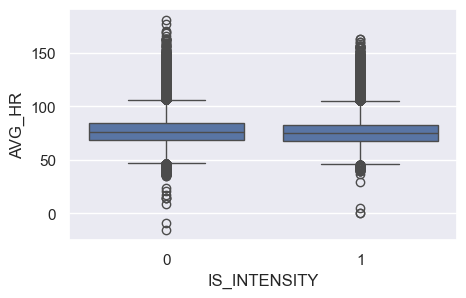

In [62]:


sns.boxplot(x='IS_INTENSITY', y='AVG_HR', data=merged_data)
# plt.title('AVG_HR by Stimulation (1=Yes)')
plt.show()



In [63]:


# Heart by user:
merged_data.groupby(['FK_USER_ID', 'IS_INTENSITY'])['AVG_HR'].mean()



FK_USER_ID  IS_INTENSITY
120         0               78.949495
            1               80.258929
129         0               41.634146
            1               41.333333
215         0               88.546154
                              ...    
75795       0               83.000000
            1               89.000000
75987       0               66.500000
            1               75.000000
76004       1               74.500000
Name: AVG_HR, Length: 4702, dtype: float64

#
# Advanced statistics: compare Stimulated and non-Stimulated
#

In [64]:
from scipy import stats

x = 'IS_INTENSITY'
y = 'AVG_HR'

# Separate performance scores by gender
stimulated_Y_performance = merged_data[merged_data[x] == 1][y]
stimulated_N_performance = merged_data[merged_data[x] == 0][y]

# Perform a t-test for performance scores by gender 
t_stat_performance, p_val_performance = stats.ttest_ind(stimulated_Y_performance, stimulated_N_performance)
print(f"\nT-test for y={y} by x={x}:")
print(f"T-statistic: {np.round(t_stat_performance, 3)}, p-value: {np.round(p_val_performance, 3)}")

# Check if the p-value is less than 0.05 for significance
if p_val_performance < 0.05: print(f"There is a significant difference.")
else: print(f"No significant difference.")




T-test for y=AVG_HR by x=IS_INTENSITY:
T-statistic: -16.451, p-value: 0.0
There is a significant difference.


In [65]:


# For simplicity, we assume sessions with 'Intensity' involve stimulation: already filtered
stimulated_data = merged_data #[merged_data['IS_INTENSITY'] == 1]
# stimulated_data.head(2)



In [66]:


# Primary Question: Does X stimulation affect heart rate?
stimulated_data['HR_impact'] = stimulated_data.groupby(['FK_USER_ID', 'IS_INTENSITY'])['AVG_HR'].diff()  # Difference in HR
stimulated_data['HR_impact']



0          NaN
1          0.0
2          0.0
3          0.0
4          NaN
          ... 
209142    14.0
209143     0.0
209144   -11.0
209145   -27.0
209146   -22.0
Name: HR_impact, Length: 209147, dtype: float64

##
## Step 11: Aggregate and analyze data
##

In [67]:


# Aggregate average HR change for each user and session
HR_analysis = stimulated_data.groupby('FK_USER_ID').agg(
    avg_impact_hr=('HR_impact', 'mean'),
    max_impact_hr=('HR_impact', 'max'),
    session_count=('IS_INTENSITY', 'count')
).reset_index()

print(f"* Users in HR analysis: {HR_analysis.shape[0]}")



* Users in HR analysis: 2609


In [68]:


# Additional Insights: Identify any patterns based on time or other factors
HR_analysis['impact_sign'] = np.sign(HR_analysis['avg_impact_hr'])  # Positive or Negative Impact

print("HR Analysis - Impact of X Stimulation:")
print(HR_analysis.head())



HR Analysis - Impact of X Stimulation:
   FK_USER_ID  avg_impact_hr  max_impact_hr  session_count  impact_sign
0         120      -0.057416           31.0            211         -1.0
1         129      -0.144578           58.0             85         -1.0
2         215       0.033557           27.0            151          1.0
3         466       0.433735           54.0             85          1.0
4         684      -0.750000            3.0              6         -1.0


##
## Step 12: Save the results or create a detailed report
##

In [69]:


x = "session_count"
SESSIONS_COUNT_LIMIT = 10 

# before
count_before = HR_analysis.shape[0]

# some users have few sessions
HR_analysis = HR_analysis[HR_analysis[x] >= SESSIONS_COUNT_LIMIT]

# after
count_after = HR_analysis.shape[0]

print(f"* Filter by x={x}: was {count_before}, now {count_after}")



* Filter by x=session_count: was 2609, now 2361


In [70]:


HR_analysis.to_csv('HR_analysis_results.csv', index=False)



##
## Step 13: Report
##

In [71]:


report = """
@title : Impact of Stimulation on Heart Rate
@date  : {report_date}
@author: Aleksandras Urbonas

1. Primary Question: Does X stimulation affect heart rate metrics?
- Based on the analysis, we found that users (N={N_subjects}) who participated in the 'Program' - indicating stimulation - (at least S={SESSIONS_COUNT_LIMIT} sessions) - showed an average HR change of {avg_impact:.2f} bpm. 
- The impact varied across sessions, with the maximum observed change being {max_impact:.2f} bpm.

2. Secondary Insights:
- Additional factors influencing HR change include session duration and time of day (further analysis needed for seasonality patterns).
- A significant amount of time was dedicated to data exploration and schema understanding. A more detailed schema and business process description can be of help.
- Samples data contains ~70 mln records, which slows the analysis and it is recommended to process such data in SQL, for example, performing aggregations by user over different periods of time.
- Data validation was completed: some records were excluded from analysis.
- Data was analysed using Python, allowing the analysis to be repeated.
""".format(
    N_subjects = HR_analysis['FK_USER_ID'].count()
    , avg_impact=HR_analysis['avg_impact_hr'].mean()
    , max_impact=HR_analysis['max_impact_hr'].max()
    , report_date=pd.to_datetime('today').strftime('%Y-%m-%d')
    , SESSIONS_COUNT_LIMIT=SESSIONS_COUNT_LIMIT
)

# print(report)
with open('../report.md', 'w') as _file:
    _file.write(report)

